# Regression on tabular data

**Agenda**:
1. Data preparation
2. Regression analysis
    1. Correlation analysis and feature engineering
    2. Multiple linear regression. Finding optimimal feature subset
    3. Simple Linear regression
        1. Simple Linear regression fitting
        2. Check for normality
        3. Check for homoscedasticity
3. Results


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from typing import Tuple

# Increase limit for number columns to display
pd.set_option('display.max_columns', 500)

## 1. Data preparation

In [30]:
TRAIN_DATASET_PATH = 'internship_train.csv'
train_df = pd.read_csv(TRAIN_DATASET_PATH)

We convert all non-float columns to float64:

In [31]:
train_df = train_df.astype(np.float64)

Number of nans in the dataset:

In [32]:
print(train_df.isnull().sum().sum())

0


Calculate simple statistics on dataset columns:

In [33]:
train_df.describe()

0             1             2             3             4  \
count  90000.000000  90000.000000  90000.000000  90000.000000  90000.000000   
mean     249.423944    250.236267    248.637289    249.736600    249.436178   
std      144.336393    144.022200    144.107577    144.284945    143.941581   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      125.000000    126.000000    124.000000    125.000000    125.000000   
50%      250.000000    251.000000    248.000000    250.000000    250.000000   
75%      374.000000    375.000000    374.000000    375.000000    373.000000   
max      499.000000    499.000000    499.000000    499.000000    499.000000   

                  5             6             7             8             9  \
count  90000.000000  90000.000000  90000.000000  90000.000000  90000.000000   
mean     249.656167     -0.011402      0.498548      0.499189    249.842033   
std      144.329168      7.038171      0.288682      0.500002    144.612718   
min        0.000000     -9.949874      0.000014      0.000000      0.000000   
25%      124.000000     -7.071068      0.248932      0.000000    124.000000   
50%      250.000000      0.000000      0.497136      0.000000    250.000000   
75%      374.000000      7.000000      0.747513      1.000000    376.000000   
max      499.000000      9.949874      0.999987      1.000000    499.000000   

                 10            11            12            13            14  \
count  90000.000000  90000.000000  90000.000000  90000.000000  90000.000000   
mean     249.818967    249.346778    249.899900      7.483940      7.498037   
std      144.363827    144.476128    144.310495      4.330908      4.318388   
min        0.000000      0.000000      0.000000      0.000095      0.000252   
25%      126.000000    124.000000    125.000000      3.723392      3.763626   
50%      250.000000    249.000000    251.000000      7.483265      7.505267   
75%      375.000000    375.000000    375.000000     11.242883     11.228331   
max      499.000000    499.000000    499.000000     14.999920     14.999938   

                 15            16            17            18            19  \
count  90000.000000  90000.000000  90000.000000  90000.000000  90000.000000   
mean       7.496259      7.501635      7.486463      7.523043      7.475585   
std        4.338732      4.345618      4.318031      4.323500      4.327327   
min        0.000190      0.000192      0.000067      0.000229      0.000125   
25%        3.718755      3.719537      3.758746      3.778857      3.733780   
50%        7.502682      7.515240      7.467721      7.539462      7.460267   
75%       11.258049     11.284618     11.238904     11.254751     11.211187   
max       14.999660     14.999979     14.999840     14.999857     14.999634   

                 20            21            22            23            24  \
count  90000.000000  90000.000000  90000.000000  90000.000000  90000.000000   
mean       7.494835      7.503939      7.507724      7.508681      7.472421   
std        4.325447      4.330159      4.332599      4.328966      4.345228   
min        0.000382      0.000398      0.000140      0.000382      0.000129   
25%        3.748951      3.760261      3.742810      3.768145      3.685140   
50%        7.481500      7.521563      7.520793      7.520739      7.484349   
75%       11.238128     11.248749     11.244657     11.240915     11.239795   
max       14.999953     14.999483     14.999762     14.999875     14.999987   

                 25            26            27            28            29  \
count  90000.000000  90000.000000  90000.000000  90000.000000  90000.000000   
mean       7.519205      7.515753      7.509402      7.496781      7.504014   
std        4.339104      4.333907      4.331007      4.334982      4.318553   
min        0.000192      0.000017      0.000080      0.000161      0.000437   
25%        3.760790      3.746467      3.772795      3.741697  

## 2. Regression analysis

### 2.A. Correlation analysis and feature engineering

**Correlation analysis** (the graph below) shows that the correlation between features 6 and 8 is high.

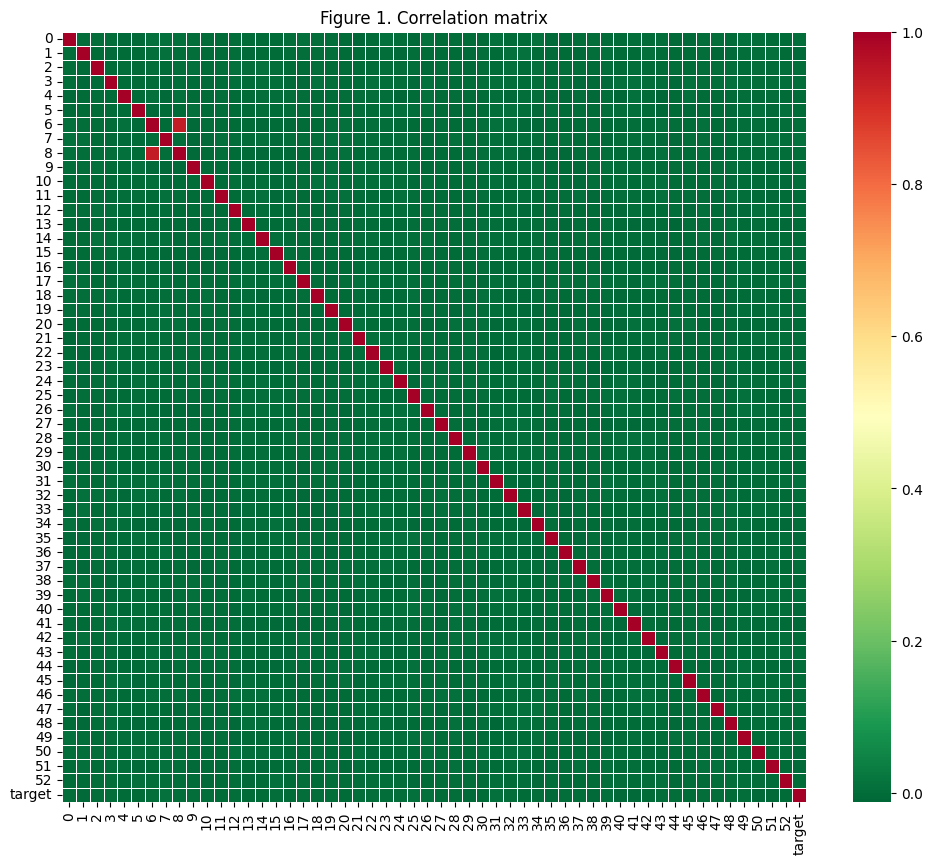

In [34]:
plt.figure(figsize=(12, 10))
train_corr = train_df.corr()
sns.heatmap(train_df.corr(), cmap='RdYlGn_r', linewidths=0.5, 
            xticklabels=train_df.columns, yticklabels=train_df.columns).set(title='Figure 1. Correlation matrix');

In [35]:
print(f"Correlation between features 6 and 8 is equal to {train_corr['6']['8']:.2f}")

Correlation between features 6 and 8 is equal to 0.94


The dependence of feature `8` on feature `6` is displayed on the following graph:

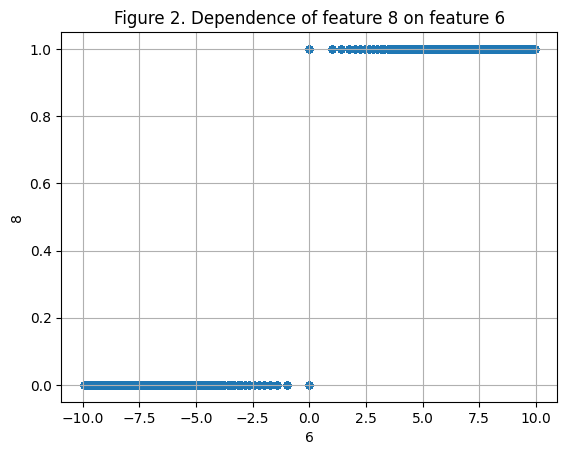

In [36]:
train_df.plot(x='6', y='8', kind='scatter', grid=True).set(title='Figure 2. Dependence of feature 8 on feature 6');

One of the variables should be excluded from the model due to multicolinearity issue. To decide on which of these two features is a better predictor, we plot the dependence of `target` variable on features `6` and `8`.

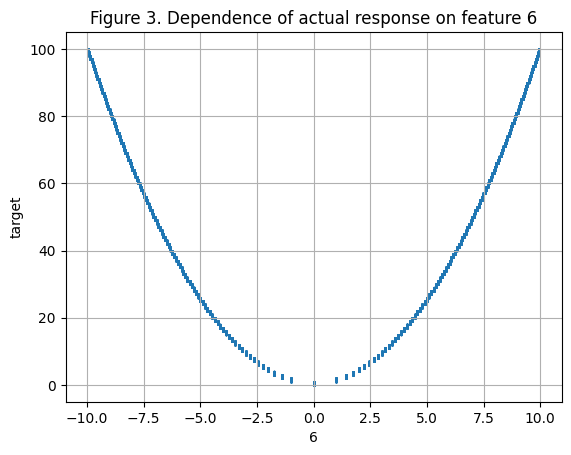

In [37]:
train_df.plot(x='6', y='target', kind='scatter', marker='.', grid=True, s=0.5).set(title='Figure 3. Dependence of actual response on feature 6');

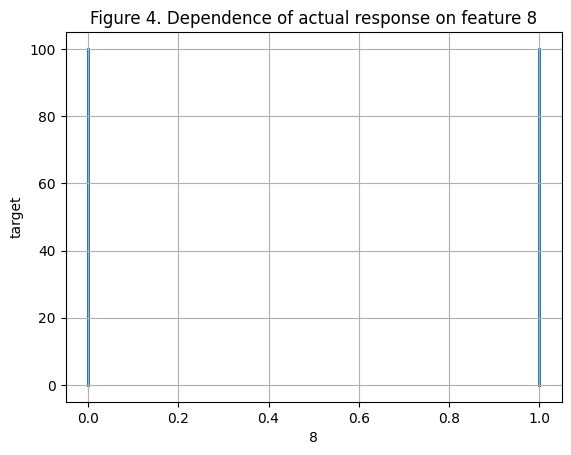

In [38]:
train_df.plot(x='8', y='target', kind='scatter', marker='.', grid=True, s=0.5).set(title='Figure 4. Dependence of actual response on feature 8');

Unexpectedly, `target` is very well predicted by feature `6`: there is a quadratic relation between `target` variable and feature `6`.

Indeed the $y = x^2$ curve gives quite a low value of RMSE metric:

In [39]:
predicted_target = train_df['6']**2
rmse = np.linalg.norm(predicted_target - train_df['target']) / predicted_target.shape[0]**0.5
print("RMSE between actual and predicted values of target:", rmse)

RMSE between actual and predicted values of target: 0.5760957925490628


We plot the dependence of `target` variable on all other variables:

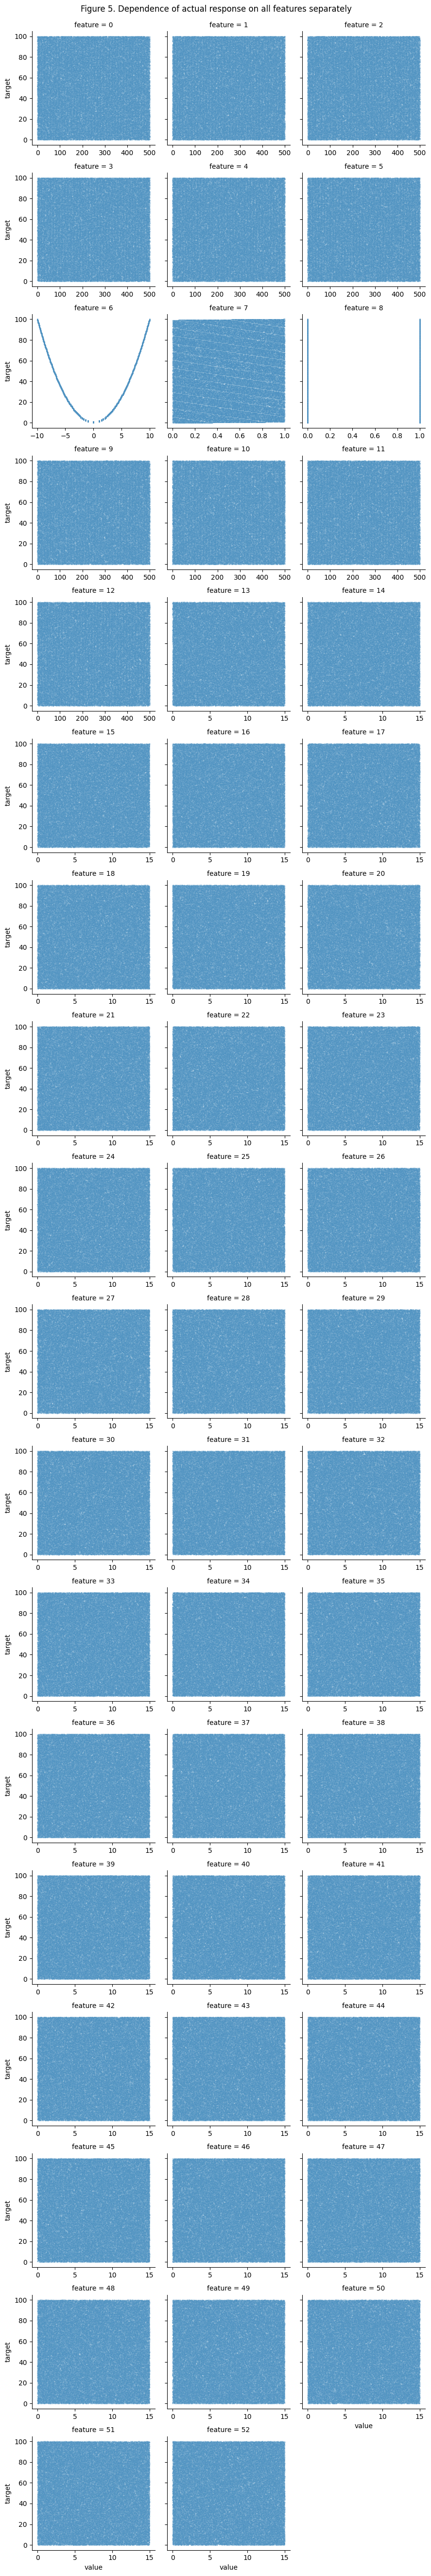

In [40]:
g = sns.FacetGrid(train_df.melt('target', var_name='feature'), col="feature", col_wrap=3, sharex=False)
g.map(sns.scatterplot, "value", "target", s=4, alpha=0.2)
g.fig.subplots_adjust(top=0.97)
g.fig.suptitle('Figure 5. Dependence of actual response on all features separately');

We don't see any other obvious feature engineering to perform. We therefore add only one new feature `53` that is equal to the squared value of feature `6`:

In [41]:
train_df['53'] = train_df['6']**2

### 3.B. Multiple linear regression. Finding optimimal feature subset

We find a feature subset that gives a satisfying value of RMSE metric on validation part of the dataset. We leverage the hold-out validation technique with 80/20 split:

In [42]:
def calc_rmse(features, labels, params) -> int:
    predictions = features @ params
    rmse = np.linalg.norm(predictions - labels) / features.shape[0]**0.5
    return rmse

def train_and_calc_rmse(train_features, train_labels, val_features, val_labels) -> Tuple[float, float]:
    train_features = sm.add_constant(train_features)
    val_features = sm.add_constant(val_features)
    
    model = sm.OLS(train_labels, train_features).fit()
    
    train_rmse = calc_rmse(train_features, train_labels, model.params)
    val_rmse = calc_rmse(val_features, val_labels, model.params)

    return train_rmse, val_rmse

VALIDATION_PART = 0.2

train_part, val_part = train_test_split(train_df, test_size=VALIDATION_PART, random_state=123)
feature_sets = {
    "All features except for 8": [str(i) for i in range(54)],
    "Feature 53 only": ["53"],
    "0-5, 7, 9-12, 53": [str(i) for i in range(6)] + ["7"] + [str(i) for i in range(9, 13)] + ["53"],
    "Only features 7 and 53": ["7", "53"],
    "All features except for 7 and 8": [str(i) for i in range(7)] + [str(i) for i in range(9, 54)],
}
for name, features in feature_sets.items():
    train_rmse, val_rmse = train_and_calc_rmse(train_part[features], train_part['target'], 
                                               val_part[features], val_part['target'])
    print(name + ':')
    print(f"\tTrain RMSE:\t {train_rmse:.2g}")
    print(f"\tVal RMSE:\t {val_rmse:.2g}")
    print()


All features except for 8:
	Train RMSE:	 3.8e-13
	Val RMSE:	 3.8e-13

Feature 53 only:
	Train RMSE:	 0.29
	Val RMSE:	 0.29

0-5, 7, 9-12, 53:
	Train RMSE:	 2.4e-13
	Val RMSE:	 2.4e-13

Only features 7 and 53:
	Train RMSE:	 1.4e-14
	Val RMSE:	 1.4e-14

All features except for 7 and 8:
	Train RMSE:	 0.29
	Val RMSE:	 0.29



We observe that using features `7` and `53` give quite a good value of RMSE metric on validation.

### 2.C. Simple Linear regression

For simplicity, we decide to model our response variable as an affine function of feature `53`.

We assume the following hypothesis about our data:
$$
\forall i \in \{1..m\}: Y_i = a + b x_i + \epsilon_i 
$$, where $m$ is the number of samples (rows), $\epsilon_1, \dots, \epsilon_m \sim \mathcal{N}(0, \sigma^2)$ are i.i.d. random variables. $x_1, x_2, \dots, x_m$ are values of feature `53`.

We use maximum likelihood estimators of $a$ and $b$, which is equivalent to finding $a$ and $b$ that minimize the ordinary least squares (OLS).

#### 2.C.a. Simple Linear regression fitting

In [43]:
y = train_df['target']
x = train_df['53']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.017e+08
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:45:03   Log-Likelihood:                -15885.
No. Observations:               90000   AIC:                         3.177e+04
Df Residuals:                   89998   BIC:                         3.179e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4975      0.002    260.499      0.000       0.494       0.501
53             1.0000   3.33e-05      3e+04      0.000       1.000       1.000
==============================================================================
Omnibus:                    77673.059   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5375.118
Skew:                           0.008   Prob(JB):                         0.00
Kurtosis:                       1.803   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
print(f"MLE estimate of a = {model.params[0]:.4f}")
print(f"MLE estimate of b = {model.params[1]:.4f}")

MLE estimate of a = 0.4975
MLE estimate of b = 1.0000


In [45]:
predictions = x @ model.params
residuals = train_df['target'] - predictions
rmse = np.linalg.norm(residuals) / predictions.shape[0]**0.5
print(f"RMSE = {rmse:.2f}")

RMSE = 0.29


$100\%$ of target volatility is explained by the developed model. Both parameters $a$ and $b$ are statically significant with respective estimates $0.4975$ and $1$. The RMSE metric is $0.29$.

#### 2.C.b. Check for normality

We check normality of residuals by plotting the "empirical pdf" of residuals. From the below graph we observe that the distribution of residuals is not Gaussian but uniform:

**Note**: ideally we had to plot the separate distribution for each of $\epsilon_1, \dots, \epsilon_m$, but from the visualized distribution of all residuals we already know that the assumpltion of $\epsilon_1, \dots, \epsilon_m$ being normal does not actually hold.

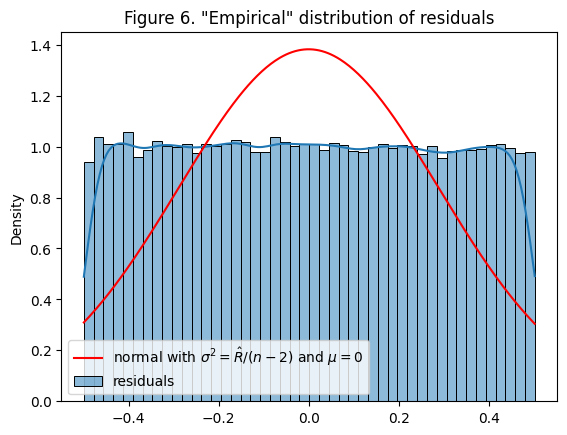

In [46]:
ax = sns.histplot(residuals, kde=True, stat='density', label='residuals')

rss = np.linalg.norm(residuals)**2

x_pdf = np.linspace(residuals.min(), residuals.max(), 300)
y_pdf = scipy.stats.norm.pdf(x_pdf, loc=0, scale=(rss / (residuals.shape[0]-2))**0.5)
ax.plot(x_pdf, y_pdf, label="normal with $\sigma^2 = \hat{R} / (n-2)$ and $\mu = 0$", c='red')
ax.set_title('Figure 6. "Empirical" distribution of residuals')
ax.legend();

#### 2.C.c. Check for homoscedasticity

We perform White's test with $\alpha = 0.05$ to determine if heteroscedasticity is present in the regression model:

**Null hypothesis**: homoscedasticity is present <br>
**Alternative hypothesis**: heteroscedasticity is present

In [47]:
white_test = het_white(model.resid,  model.model.exog)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
for label, val in zip(labels, white_test):
    print(f"{label}: {val:.2f}")

Test Statistic: 0.32
Test Statistic p-value: 0.85
F-Statistic: 0.16
F-Test p-value: 0.85


Based on the calculated $p$-value, we do not reject the null hypotheses. The residuals have equal deviations.

## 3. Results

* We add new feature `53` that is a squared value of feature `6`
* We perform validation and find out that features `7` and `53` are pretty good to train Multiple Linear regression on. We base this decision on the value of RMSE metric on the validation part: $ 1.4 \cdot 10^{-14} $
* For simplicity, we train Simple Linear regression using the `target` variable and new feature `53`:
    * We obtain a relatively small value of RMSE metric: $0.29$
    * We obtain a $100\%$ explainability of the volatility of `target` by the regression model
    * The fitted model is as follows: `target` $= 0.4975 +$ `feature 6`$^2$
    * Distribution of residuals is not normal, but homoscedasticity is satisfied